In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("horse.csv")

In [3]:
df

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,yes,adult,533886,NaN,120.0,70.0,cold,NaN,pale_cyanotic,more_3_sec,...,55.0,65.0,NaN,NaN,euthanized,no,3205,0,0,no
295,no,adult,527702,37.2,72.0,24.0,cool,increased,pale_cyanotic,more_3_sec,...,44.0,NaN,serosanguious,3.3,euthanized,yes,2208,0,0,yes
296,yes,adult,529386,37.5,72.0,30.0,cold,reduced,pale_cyanotic,less_3_sec,...,60.0,6.8,NaN,NaN,died,yes,3205,0,0,no
297,yes,adult,530612,36.5,100.0,24.0,cool,reduced,pale_pink,less_3_sec,...,50.0,6.0,serosanguious,3.4,lived,yes,2208,0,0,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   hospital_number        299 non-null    int64  
 3   rectal_temp            239 non-null    float64
 4   pulse                  275 non-null    float64
 5   respiratory_rate       241 non-null    float64
 6   temp_of_extremities    243 non-null    object 
 7   peripheral_pulse       230 non-null    object 
 8   mucous_membrane        252 non-null    object 
 9   capillary_refill_time  267 non-null    object 
 10  pain                   244 non-null    object 
 11  peristalsis            255 non-null    object 
 12  abdominal_distention   243 non-null    object 
 13  nasogastric_tube       195 non-null    object 
 14  nasogastric_reflux     193 non-null    object 
 15  nasoga

In [5]:
df.nunique()

surgery                    2
age                        2
hospital_number          283
rectal_temp               40
pulse                     52
respiratory_rate          40
temp_of_extremities        4
peripheral_pulse           4
mucous_membrane            6
capillary_refill_time      3
pain                       5
peristalsis                4
abdominal_distention       4
nasogastric_tube           3
nasogastric_reflux         3
nasogastric_reflux_ph     20
rectal_exam_feces          4
abdomen                    5
packed_cell_volume        50
total_protein             80
abdomo_appearance          3
abdomo_protein            37
outcome                    3
surgical_lesion            2
lesion_1                  61
lesion_2                   6
lesion_3                   2
cp_data                    2
dtype: int64

In [6]:
#The features lesion1, 2 and 3 will give us trouble because the way they are formated doesn't make any sense. 
#Therefore, we will create a new feature that counts the number of lesions the horse has to replace them.
df.loc[df['lesion_1'] > 0, 'lesion_1'] = 1
df.loc[df['lesion_2'] > 0, 'lesion_2'] = 1
df.loc[df['lesion_3'] > 0, 'lesion_3'] = 1

df['num_lesions'] = df['lesion_1'] + df['lesion_2'] + df['lesion_3']
df = df.drop(columns = ['lesion_1','lesion_2', 'lesion_3'], axis = 1)

In [7]:
def get_feature_stats_nan(df):
    """function take dataFrame and compute the number of missing value in eache feature
        and compute the percentage of missing.
    Args:
        df ([DataFrame]): [DataFrame we want to compute the missing values]

    Returns:
        [DataFrame]: [dataFrame containing four columns [feature_name,  missing_count, missing_percentage]]
    """
    missing_df = df.isna().sum().sort_values(ascending=False).rename('missing_count').reset_index().rename(columns={'index':'feature_name'})
    missing_df['missing_percentage'] = missing_df['missing_count']/df.shape[0]*100
    
    
    return missing_df
 
#Checking the percentage of missing values in each column by dividing by the number of rows,
# and multiplying by 100
missing_data = get_feature_stats_nan(df)
missing_data

,feature_name,missing_count,missing_percentage
0,nasogastric_reflux_ph,246,82.274247
1,abdomo_protein,198,66.220736
2,abdomo_appearance,165,55.183946
3,abdomen,118,39.464883
4,nasogastric_reflux,106,35.451505
5,nasogastric_tube,104,34.782609
6,rectal_exam_feces,102,34.113712
7,peripheral_pulse,69,23.076923
8,rectal_temp,60,20.066890
9,respiratory_rate,58,19.397993


- Now we will decide on a way to handle our missing data:
    - First we will drop any column that has a missing percentage above 50%.
    - Then we will check for a suitable way to fill our missing data.
        - First we will fill our numeric data using Knn algorithm.
        - Then after vieweing our unique values in the dataframe,
        - we can assume that a perfect way is to fill it with the,
        - most frequent as there is not that much data missing.
    - After filling all the missing data we will handle noisy data and,
    - remove any outliers if existed.

In [8]:
# drop any column that has a missing percentage above 50%.
features_to_delete = missing_data[missing_data['missing_percentage'] >= 50]['feature_name'].values
len(features_to_delete)

3

In [9]:
df.drop(columns=features_to_delete, inplace=True)

In [10]:
# get only numerical columns
numerics_colnames = df.select_dtypes(include=np.number).columns.tolist()
# get only categorical columns
categorical_colnames = df.select_dtypes(include=np.object_).columns.tolist()

# remove unnecessary columns from the preprocessing and EDA phases
numerics_colnames.remove('hospital_number')
categorical_colnames.remove('cp_data')

In [13]:
def fill_numeric(numeric_columns, df):
    """This function fills the numeric missing values from
    the original data frame that you sent to this funciton

    Args:
        df (_type_): This is the original data frame sent to the functiuon

    Returns:
        _type_: Edited Pandas dataframe
    """
    imputer = KNNImputer(n_neighbors=3)
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
  

def fill_object(df):
    """This function fill categorial type data using mode,
    it loops through ever column taking it's most frequent,
    then filling the nan values in that column with the mode.

    Args:
        df (_type_): This is the original data frame sent to this funciton

    Returns:
        _type_: Edited Pandas dataframe
    """
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

def remove_outlier(col_name, df_in, Q1=True, Q3=True):
   
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    if Q1 and Q3:
        df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    elif Q1:
        df_out = df_in.loc[(df_in[col_name] > fence_low)]
    elif Q3:
        df_out = df_in.loc[(df_in[col_name] < fence_high)]
 
    return df_out

   

In [14]:
fill_numeric(numerics_colnames, df)

- After handling all the missing data we can now check for noisy,
- and outliers.

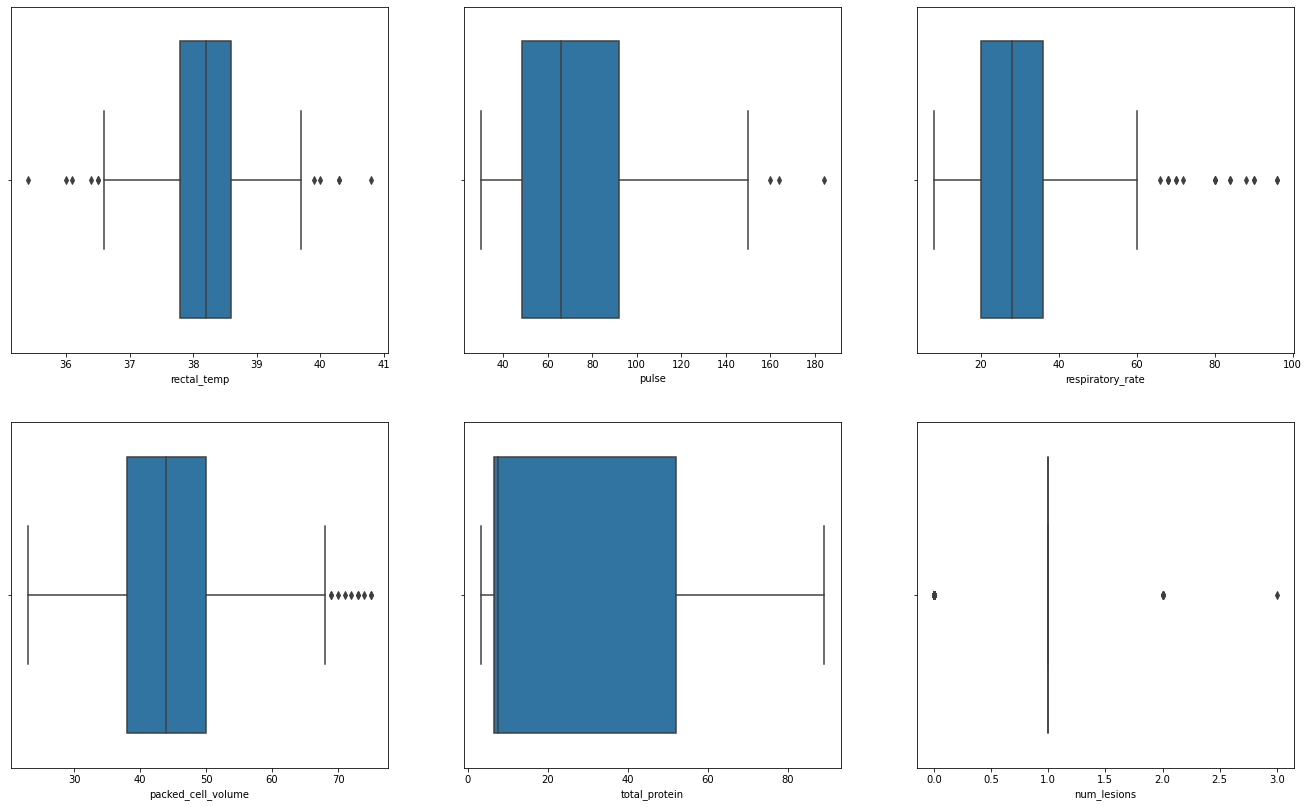

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(23, 14)
index = 0
for i in range(2):
    for j in range(3):
        sns.boxplot(data=df, x=numerics_colnames[index], ax=axes[i][j])
        index += 1
    

it makes no sense to remove outliers from columns because:
- rectal_temp
    - An elevated temp may occur due to infection. 
    - temperature may be reduced when the animal is in late shock
- pulse 
    - animals with painful lesions or suffering from circulatory shock may have an elevated heart rate
- packed_cell_volume
    - the number of red cells by volume in the blood 
    - normal range is 30 to 50. The level rises as the circulation becomes compromised or as the animal becomes dehydrated. 
- num_lesions
    - number of lesions between 0 and 3 


remove outliers from columns because:
- respiratory_rate
    - normal rate is 8 to 10 
    - usefulness is doubtful due to the great fluctuations 

##### In the next section we will clean our data from the outliers, using quartiles.

In [16]:
df_clean =  remove_outlier('respiratory_rate', df.copy(), Q1=False)

In [17]:
get_feature_stats_nan(df_clean[categorical_colnames])

,feature_name,missing_count,missing_percentage
0,abdomen,105,37.769784
1,nasogastric_reflux,95,34.172662
2,rectal_exam_feces,95,34.172662
3,nasogastric_tube,94,33.812950
4,peripheral_pulse,64,23.021583
5,temp_of_extremities,51,18.345324
6,abdominal_distention,49,17.625899
7,pain,47,16.906475
8,mucous_membrane,43,15.467626
9,peristalsis,41,14.748201


In [18]:
df_clean = fill_object(df_clean.copy())
get_feature_stats_nan(df_clean)

,feature_name,missing_count,missing_percentage
0,surgery,0,0.0
1,abdominal_distention,0,0.0
2,cp_data,0,0.0
3,surgical_lesion,0,0.0
4,outcome,0,0.0
5,total_protein,0,0.0
6,packed_cell_volume,0,0.0
7,abdomen,0,0.0
8,rectal_exam_feces,0,0.0
9,nasogastric_reflux,0,0.0


# EDA

<AxesSubplot:>

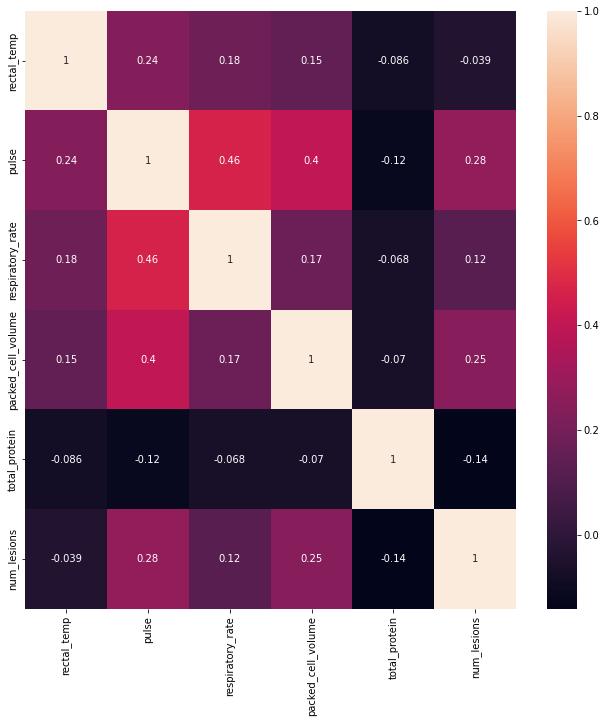

In [19]:
plt.figure(figsize=(11, 11))
sns.heatmap(df_clean[numerics_colnames].corr(), annot=True) 
# مافي علاقة واضحة بين اي تنين فيتشر مع بعض

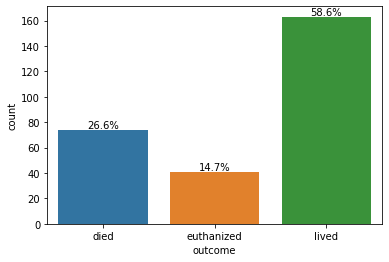

In [20]:
plot = sns.countplot(data=df_clean, x='outcome')
for p in plot.patches:
    plot.annotate('{:.1f}%'.format((p.get_height()/len(df_clean['outcome']))*100), 
                        (p.get_x()+0.4, p.get_height()), ha='center', va='bottom') 

### Show all categorical features and beneficial use of them for our study

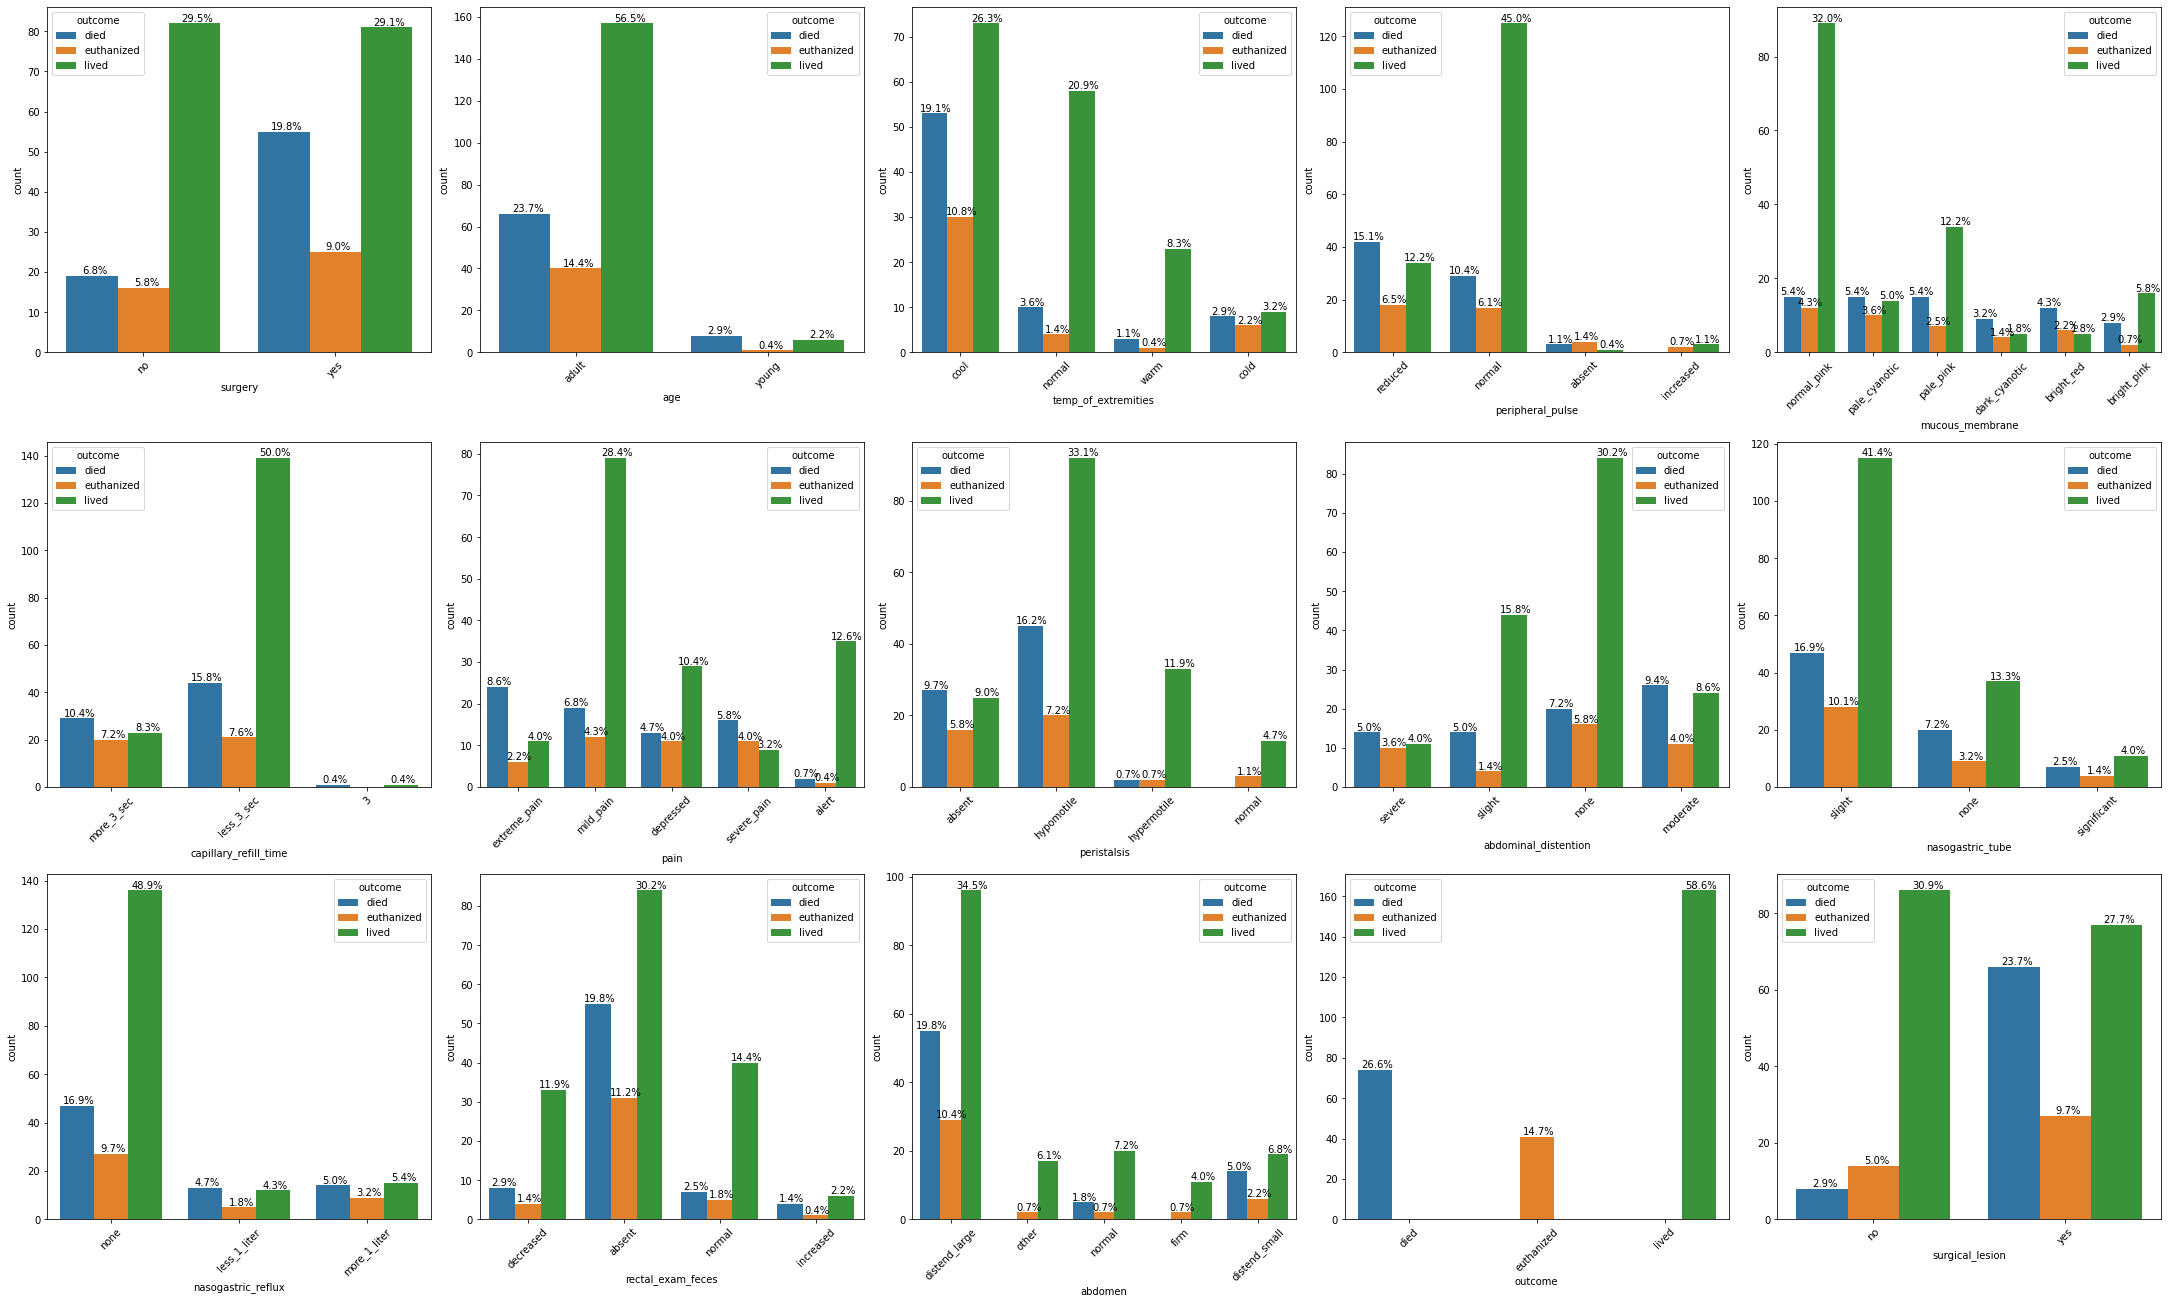

In [21]:
n_rows = 3
n_cols = 5
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30, 18), constrained_layout=True)

index = 0
for i in range(n_rows):
    for j in range(n_cols):
        plot = sns.countplot(data=df_clean, x=categorical_colnames[index], hue='outcome', ax=axes[i][j]) 
        plot.tick_params(axis='x', rotation=45)
        
        for p in plot.patches:
            plot.annotate('{:.1f}%'.format((p.get_height()/len(df_clean[categorical_colnames[index]]))*100), 
                           (p.get_x()+0.15, p.get_height()), ha='center', va='bottom')
        
        index += 1

In [66]:
nedded_colnames = ['age', 'surgery', 'temp_of_extremities','peripheral_pulse','capillary_refill_time','pain', 'peristalsis', 'abdominal_distention', 'rectal_exam_feces', 'abdomen', 'surgical_lesion']
n_nedded =  len(nedded_colnames)

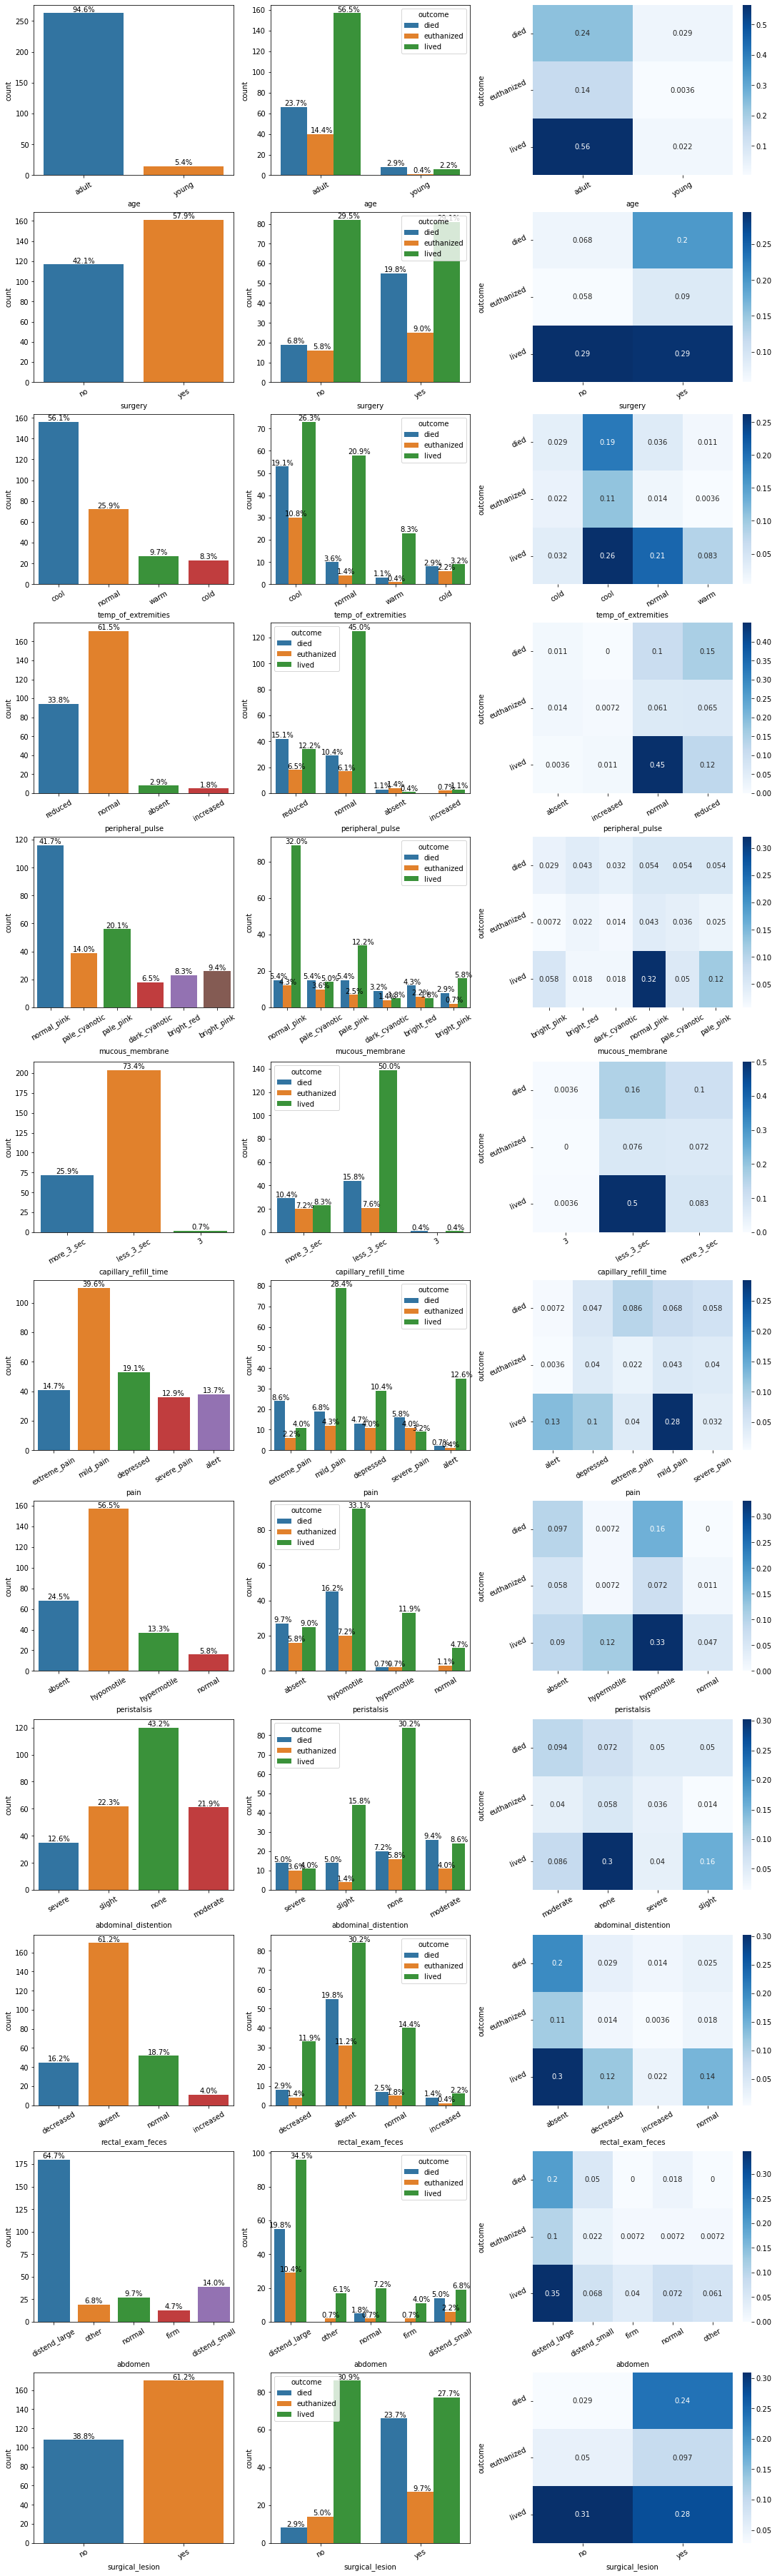

In [67]:
fig, axes = plt.subplots(nrows=n_nedded, ncols=3, figsize=(15, 50), constrained_layout=True)

for i in range(n_nedded):
    for j in range(3): 
        LEN = len(df_clean[nedded_colnames[i]])
        if j == 0:
            plot = sns.countplot(data=df_clean, x=nedded_colnames[i], ax=axes[i][j]) 
            for p in plot.patches:
                plot.annotate('{:.1f}%'.format((p.get_height()/LEN)*100), 
                               (p.get_x()+0.4, p.get_height()), ha='center', va='bottom')
        elif j == 1:
            plot = sns.countplot(data=df_clean, x=nedded_colnames[i], hue='outcome', ax=axes[i][j])
            for p in plot.patches:
                plot.annotate('{:.1f}%'.format((p.get_height()/LEN)*100), 
                               (p.get_x()+0.15, p.get_height()), ha='center', va='bottom')
        else:
            table = pd.crosstab(df_clean['outcome'], df_clean[nedded_colnames[i]], normalize=True) 
            plot = sns.heatmap(table, annot=True, cmap="Blues", ax=axes[i][j])
            plot.tick_params(axis='y', rotation=25)
   
        plot.tick_params(axis='x', rotation=30)

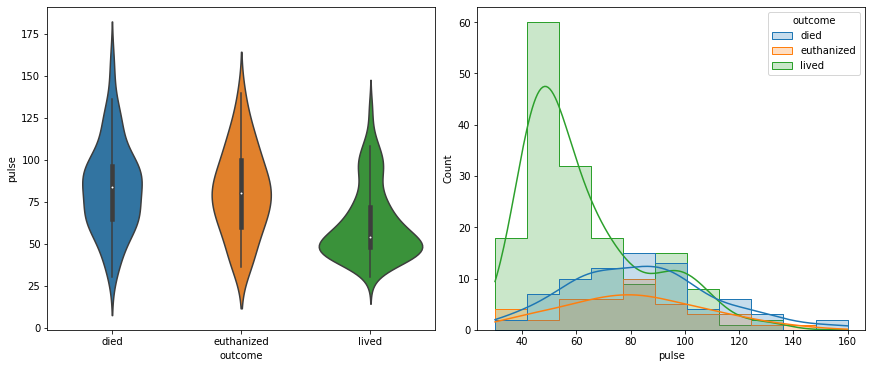

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Create a violin plot of the 'pulse' column by 'outcome' category
sns.violinplot(data=df_clean, x='outcome', y='pulse', ax=axes[0])
# This plot allows to visualize the distribution of pulse values for each outcome category and compare them.
sns.histplot(data=df_clean, x='pulse', hue='outcome', kde=True, element="step", ax=axes[1] )

plt.show()

It seems that after approximately 70 of pulse, the horse is likely to die (died or be euthanized).

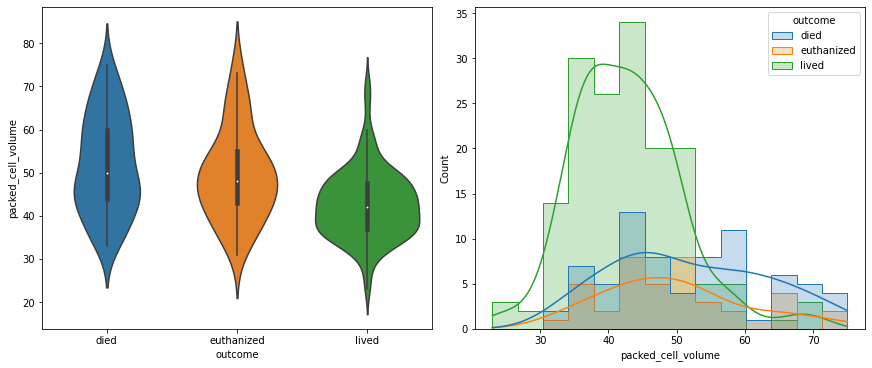

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Create a violin plot of the 'pulse' column by 'outcome' category
sns.violinplot(data=df_clean, x='outcome', y='packed_cell_volume', ax=axes[0])
# This plot allows to visualize the distribution of pulse values for each outcome category and compare them.
sns.histplot(data=df_clean, x='packed_cell_volume', hue='outcome', kde=True, element="step", ax=axes[1] )

plt.show()

It seems that after approximately 50 of Packed cell volume, horses begin to die (died or be euthanized).

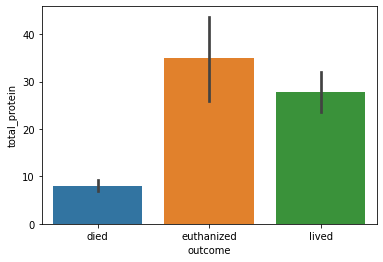

In [55]:
sns.barplot(data=df_clean, y='total_protein', x='outcome')
plt.show()

It seems to us that the horses that died took little total protein, and the horses that were euthanized got a lot of total protein, while the horses that lived had a moderate total protein.

# The End